In [8]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from setting.setting import *
import matplotlib.pyplot as plt

In [9]:
data_dir = "../../dataset/processed/v1/training"
val_data_dir = "../../dataset/processed/v1/validation"
model_dir = "../../models/VGG16"
best_model_filename = 'vgg16_best_model_v1.pth'
os.makedirs(model_dir, exist_ok=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.RandomResizedCrop((IMG_HEIGHT, IMG_WIDTH), scale=(0.9, 1.0)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

train_dataset = datasets.ImageFolder(root=data_dir, transform=data_transforms['train'])
val_dataset = datasets.ImageFolder(root=val_data_dir, transform=data_transforms['val'])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

In [11]:
base_model = models.vgg16(pretrained=True)
for param in base_model.parameters():
    param.requires_grad = False
num_features = base_model.classifier[6].in_features
base_model.classifier[6] = nn.Linear(num_features, 26)
model = base_model.to(device)

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.0001)

In [13]:
def evaluate(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    avg_loss = total_loss / len(data_loader)
    accuracy = correct / total
    return avg_loss, accuracy

In [14]:
best_val_acc = 0.0
best_val_loss = float('inf')
patience = 20
final_total_epochs = 1000
history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}

for epoch in range(final_total_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    history['loss'].append(train_loss)
    history['accuracy'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_accuracy'].append(val_acc)

    print(f'Epoch {epoch+1}/{final_total_epochs}, Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), os.path.join(model_dir, best_model_filename))
        print('Model saved')

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        loss_no_improve = 0
    else:
        loss_no_improve += 1

    if loss_no_improve >= patience:
        print('Early stopping triggered')
        break

Epoch 1/100, Loss: 2.1007, Accuracy: 0.4889, Val Loss: 1.2895, Val Acc: 0.8000
Model saved
Epoch 2/100, Loss: 1.1748, Accuracy: 0.7461, Val Loss: 0.8422, Val Acc: 0.8467
Model saved
Epoch 3/100, Loss: 0.9027, Accuracy: 0.7900, Val Loss: 0.6488, Val Acc: 0.8897
Model saved
Epoch 4/100, Loss: 0.7615, Accuracy: 0.8162, Val Loss: 0.5483, Val Acc: 0.8937
Model saved
Epoch 5/100, Loss: 0.6842, Accuracy: 0.8275, Val Loss: 0.4706, Val Acc: 0.9132
Model saved
Epoch 6/100, Loss: 0.6296, Accuracy: 0.8390, Val Loss: 0.4265, Val Acc: 0.9148
Model saved
Epoch 7/100, Loss: 0.5825, Accuracy: 0.8486, Val Loss: 0.3850, Val Acc: 0.9233
Model saved
Epoch 8/100, Loss: 0.5576, Accuracy: 0.8507, Val Loss: 0.3605, Val Acc: 0.9258
Model saved
Epoch 9/100, Loss: 0.5291, Accuracy: 0.8568, Val Loss: 0.3380, Val Acc: 0.9310
Model saved
Epoch 10/100, Loss: 0.5091, Accuracy: 0.8608, Val Loss: 0.3155, Val Acc: 0.9339
Model saved
Epoch 11/100, Loss: 0.4945, Accuracy: 0.8622, Val Loss: 0.3035, Val Acc: 0.9343
Model sav

In [15]:
print(f"Mô hình tốt nhất đã được lưu tại: {os.path.join(model_dir, best_model_filename)}")

Mô hình tốt nhất đã được lưu tại: ../../models/VGG16\vgg16_best_model_v1.pth


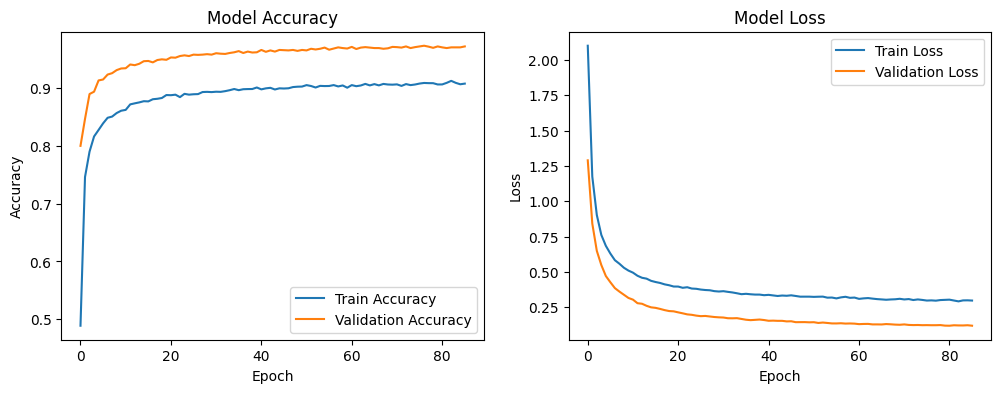

In [16]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [17]:
print(f"Mô hình tốt nhất đã được lưu tại: {os.path.join(model_dir, best_model_filename)}")

Mô hình tốt nhất đã được lưu tại: ../../models/VGG16\vgg16_best_model_v1.pth
